## <center>Применение SQL для решения типовых бизнес-задач: Составление запросов к базе данных Chinook</center>
                                                       Проект выполнен: Резвухин Д.И., октябрь 2022 г.

### Введение 

В рамках реализации данного проекта мы будем работать с базой данных Chinook — выдуманного цифрового онлайн-сервиса по покупке музыкальных треков и альбомов. Эта база данных состоит из ряда таблиц, содержащих информацию об исполнителях, альбомах, музыкальных треках, счетах и покупателях. Данные о мультимедиа были созданы с использованием реальных данных из библиотеки iTunes. Информация о клиентах и сотрудниках была создана вручную с использованием вымышленных имен, адресов, которые можно найти на картах Google, и других хорошо отформатированных данных (телефон, факс, электронная почта и т.д.). Информация о продажах сгенерирована автоматически с использованием случайных данных за четырехлетний период. Chinook часто используется для тестирования ORM и прокачки навыков SQL. 

Название базы данных основано на аналогии с другой известной базой данных — Northwind. [Шинук (Чинук)](https://ru.wikipedia.org/wiki/%D0%A8%D0%B8%D0%BD%D1%83%D0%BA)  — юго-западный ветер на восточных склонах Скалистых гор в Канаде и США, а также на прилегающих к ним участках прерий. 

Цель данного проекта заключается в извлечении необходимой информации из базы данных посредством выполнения SQL-запросов на диалекте SQLite. Проблематика задач отражает типичные случаи применения, которые могут возникнуть при работе подобного музыкального онлайн-магазина.

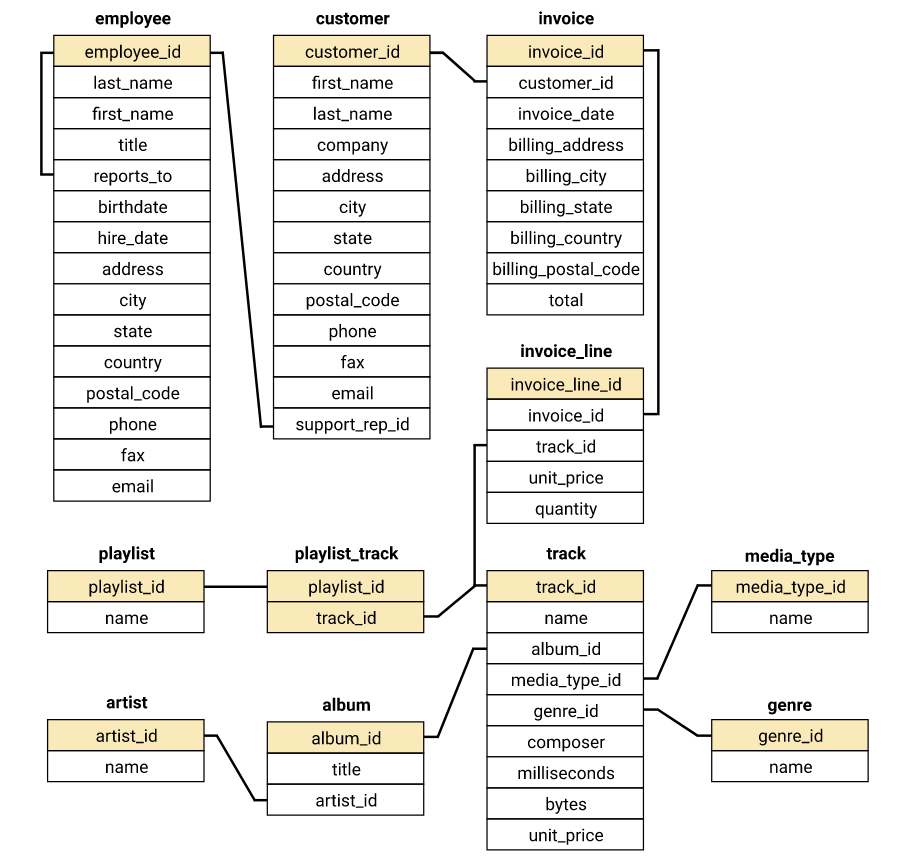

### Подключение к базе данных и отображение списка имеющихся таблиц

Используем следующий код, чтобы подключиться к базе данных Chinook. 

In [1]:
%load_ext sql
%sql sqlite:///chinook.db

'Connected: @chinook.db'

In [2]:
%%sql
SELECT name, 
       type
  FROM sqlite_master
 WHERE type IN ("table", "view");

 * sqlite:///chinook.db
Done.


name,type
album,table
artist,table
customer,table
employee,table
genre,table
invoice,table
invoice_line,table
media_type,table
playlist,table
playlist_track,table


### Запрос 1: Выявление исполнителей, которые являются лидерами в плейлистах

В базе данных Chinook имеются встроенные плейлисты, состоящие из различных треков. Такие плейлисты клиенты могут покупать либо использовать для составления собственных. Текущей задачей является выявление топа исполнителей, которые присутствуют в наибольшем количестве таких встроенных плейлистов. Вывод ограничить десятью исполнителями.

In [3]:
%%sql
SELECT artist.name AS artist,
       COUNT(DISTINCT playlist_track.playlist_id) AS number_of_playlists
  FROM artist
       INNER JOIN album USING(artist_id)
       INNER JOIN track USING(album_id)
       INNER JOIN playlist_track USING(track_id)
 GROUP BY 1
 ORDER BY 2 DESC
 LIMIT 10;

 * sqlite:///chinook.db
Done.


artist,number_of_playlists
Eugene Ormandy,7
The King's Singers,6
English Concert & Trevor Pinnock,6
Berliner Philharmoniker & Herbert Von Karajan,6
Academy of St. Martin in the Fields & Sir Neville Marriner,6
Yo-Yo Ma,5
Wilhelm Kempff,5
Ton Koopman,5
"Sir Georg Solti, Sumi Jo & Wiener Philharmoniker",5
Sir Georg Solti & Wiener Philharmoniker,5


### Запрос 2: Сравнение эффективности сотрудников магазина

Когда клиент магазина Chinook впервые совершает покупку, ему назначается менеджер по продажам. Спустя определенный период времени имеет смысл проанализировать покупки клиентов и оценить эффективность менеджеров. Для оценки эффективности можно использовать некоторую дополнительную информацию из базы данных, которая поможет объяснить то или иное значение. Мы учтем возраст сотрудника, дату приема на работу и количество клиентов.

In [4]:
%%sql  
SELECT e.last_name || " " || e.first_name AS employee_name,
       ROUND(SUM(total), 1) AS total_sale_amount,
       COUNT(c.customer_id) AS number_of_customers,
       birthdate,
       hire_date
  
  FROM employee AS e
       INNER JOIN customer AS c ON c.support_rep_id = e.employee_id
       INNER JOIN invoice AS i ON i.customer_id = c.customer_id
 
 GROUP BY 1, 4, 5
 ORDER BY 2 DESC;

 * sqlite:///chinook.db
Done.


employee_name,total_sale_amount,number_of_customers,birthdate,hire_date
Peacock Jane,1731.5,212,1973-08-29 00:00:00,2017-04-01 00:00:00
Park Margaret,1584.0,214,1947-09-19 00:00:00,2017-05-03 00:00:00
Johnson Steve,1393.9,188,1965-03-03 00:00:00,2017-10-17 00:00:00


Лидером по общей сумме продаж является Peacock Jane. Она же является самым молодым продавцом, но при этом имеет самый большой стаж работы в магазине. Учитывая даты приема на работу и количество клиентов, нет оснований полагать, что кто-то из сотрудников справляется с обязанностями плохо.

### Запрос 3: Выявление самых продаваемых треков (с указанием альбома и исполнителя)

Составление различных топов — типичный вид SQL-запросов, и зачастую требуется как для получения информации, важной для бизнеса, так и для более "казуальных" задач (например, в случае, если маркетинговый отдел захочет провести в социальных сетях опрос-конкурс). В данном задании требуется вывести список наиболее продаваемых треков с указанием альбома и исполнителя. Вывод ограничить десятью треками.

In [5]:
%%sql
SELECT track.name AS track_name,
       album.title AS album,
       artist.name AS artist,
       COUNT(invoice_line.track_id) AS number_of_purchases

 FROM invoice_line 
      INNER JOIN track USING(track_id)
      INNER JOIN album USING(album_id)
      INNER JOIN artist USING(artist_id)
     
 GROUP BY 1, 2, 3
 ORDER BY 4 DESC
 LIMIT 10;

 * sqlite:///chinook.db
Done.


track_name,album,artist,number_of_purchases
War Pigs,Cake: B-Sides and Rarities,Cake,31
Are You Experienced?,Are You Experienced?,Jimi Hendrix,14
Highway Chile,Are You Experienced?,Jimi Hendrix,14
Hey Joe,Are You Experienced?,Jimi Hendrix,13
Put The Finger On You,For Those About To Rock We Salute You,AC/DC,13
Third Stone From The Sun,Are You Experienced?,Jimi Hendrix,13
Love Or Confusion,Are You Experienced?,Jimi Hendrix,12
Radio/Video,Mezmerize,System Of A Down,12
51st Anniversary,Are You Experienced?,Jimi Hendrix,11
Dead And Broken,Faceless,Godsmack,11


### Запрос 4: Выявление исполнителя с самых большим числом проданных треков

Запрос требуется написать корректно для возможного случая, когда есть несколько исполнителей, которые делят первое место по числу проданных треков. 

In [6]:
%%sql
SELECT artist.name AS artist,
       SUM(quantity) AS number_of_tracks_sold
  FROM artist
       INNER JOIN album USING(artist_id)
       INNER JOIN track USING(album_id)
       INNER JOIN invoice_line USING(track_id)
 GROUP BY 1
HAVING SUM(quantity) = (
                        SELECT MAX(track_amount)
                          FROM (
                                SELECT artist.name AS artist,
                                       SUM(quantity) AS track_amount
                                  FROM invoice_line
                                       INNER JOIN track USING(track_id)
                                       INNER JOIN album USING(album_id)
                                       INNER JOIN artist USING(artist_id)     
                                 GROUP BY 1
                               )
                       );

 * sqlite:///chinook.db
Done.


artist,number_of_tracks_sold
Queen,192


In [7]:
%%sql
-- вариант запроса с CTE (WITH)

WITH tracks_sold AS 
    (
     SELECT artist.name AS artist,
            SUM(quantity) AS track_amount
       FROM invoice_line
            INNER JOIN track USING(track_id)
            INNER JOIN album USING(album_id)
            INNER JOIN artist USING(artist_id)     
      GROUP BY artist.name
    )

SELECT artist,
       track_amount 
  FROM tracks_sold
 WHERE track_amount = (
                       SELECT MAX(track_amount)
                         FROM tracks_sold
                      );

 * sqlite:///chinook.db
Done.


artist,track_amount
Queen,192


### Запрос 5: Выявление наиболее популярных жанров музыки при продвижении нового контента

Предположим, что магазин Chinook подписал контракт с новым лейблом, согласно которому из четырех альбомов новых исполнителей нужно выбрать три, чтобы добавить их в цифровом виде на платформу. Исполнители специализируются на музыке различных жанров, в первую очередь для аудитории из США. Лейблом рекомендованы следующие исполнители с указанием жанра: Regal (Hip-Hop), Red Tone (Alternative), Meteor and the Girls (R&B/Soul) и Slim Jim Bites (Blues).

Чтобы определить, каких именно исполнителей следует выбрать, нужно понять, какие жанры музыки пользуются популярностью, после чего добавить в сервис альбомы, жанр которых соответствует топ-3 популярным жанрам на платформе Chinook.

Для этого напишем SQL-запрос, где сгруппируем данные по продажам по жанрам. Критерием популярности будем считать количество проданных треков соответствующего жанра.

Дополнительно используем библиотеку pandas и средства визуализации, чтобы построить бар-диаграмму.

In [8]:
import sqlite3
import pandas as pd

query = """
WITH usa_tracks_sold AS
    (
     SELECT *
       FROM genre
            INNER JOIN track USING(genre_id)
            INNER JOIN invoice_line USING(track_id)
            INNER JOIN invoice USING(invoice_id)
      WHERE billing_country = 'USA'
    ) 

SELECT name AS music_style,
       SUM(quantity) AS number_of_tracks_sold,
       ROUND(1.0 * COUNT(*) / SUM(COUNT(*)) OVER(), 3) AS proportion                         
  FROM usa_tracks_sold
 GROUP BY 1  
 ORDER BY 2 DESC;
"""

conn = sqlite3.connect("chinook.db")
df = pd.read_sql_query(query, conn) 
conn.close()

df

,music_style,number_of_tracks_sold,proportion
0,Rock,561,0.534
1,Alternative & Punk,130,0.124
2,Metal,124,0.118
3,R&B/Soul,53,0.050
4,Blues,36,0.034
5,Alternative,35,0.033
6,Latin,22,0.021
7,Pop,22,0.021
8,Hip Hop/Rap,20,0.019
9,Jazz,14,0.013


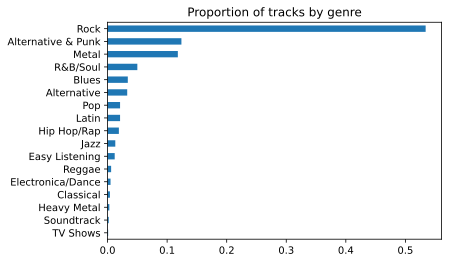

In [9]:
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline  
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')  

df.sort_values(by='proportion').plot.barh(x='music_style', y='proportion', legend=False)
plt.title('Proportion of tracks by genre')
plt.ylabel('')
plt.show()

С большим отрывом на платформе Chinook лидирует рок. Из прочих жанров панк, R&B и блюз более популярны, чем хип-хоп, поэтому, согласно выбранному критерию, в сервис будут добавлены альбомы исполнителей Red Tone, Meteor and the Girls и Slim Jim Bites.

### Запрос 6: Выявление наиболее продаваемых альбомов по странам проживания покупателей

В рамках данного запроса нам предстоить определить самые продаваемые альбомы в различных странах. В магазине Chinook в основном покупаются не альбомы целиком, а отдельные треки, поэтому мерой популярности альбома будем считать общую сумму выручки для треков с этого альбома.



In [10]:
%%sql

/*
Для выполнения данного задания удобнее всего сделать CTE-таблицу `country_album`, 
отображающую альбомы и сумму продаж треков по странам.

Чтобы определить, какие альбомы имеют максимальные суммы продаж (по странам), 
мы не можем в дополнительном запросе к этому CTE просто указать агрегатную функцию MAX() 
и выбрать группировку только по странам, 
так как в `GROUP BY` должны присутствовать все столбцы из `SELECT` (помимо страны),
а это приведет в данном случае к некорректным результатам.

Для правильного отображения результатов, 
совместим через INNER JOIN `country_album` c выборкой из этого CTE,
в которой как раз и будет посчитана максимальная сумма выкупа (по стране),
при этом в условии соединения укажем, что сопоставление осуществляется как по стране,
так и по сумме выкупа.
*/

WITH country_album AS
    (
     SELECT customer.country AS country,
            artist.name AS artist,
            album.title AS album,
            ROUND(SUM(invoice_line.unit_price * invoice_line.quantity), 3) AS total_purchased
       FROM customer
            INNER JOIN invoice USING(customer_id)
            INNER JOIN invoice_line USING(invoice_id)
            INNER JOIN track USING(track_id)
            INNER JOIN album USING(album_id)
            INNER JOIN artist USING(artist_id)
      GROUP BY 1, 2, 3
      ORDER BY 1, 3 DESC
    )

SELECT ca.*
  FROM country_album AS ca
       INNER JOIN (
                   SELECT country,
                          MAX(total_purchased) AS total_purchased
                     FROM country_album
                    GROUP BY 1
                  ) sub ON ca.total_purchased = sub.total_purchased
                        AND ca.country = sub.country
 ORDER BY 1;

 * sqlite:///chinook.db
Done.


country,artist,album,total_purchased
Argentina,Green Day,American Idiot,12.87
Australia,The Clash,The Singles,17.82
Austria,Miles Davis,Miles Ahead,13.86
Belgium,Godsmack,Faceless,11.88
Brazil,JET,Get Born,28.71
Canada,The Who,My Generation - The Very Best Of The Who,27.72
Chile,Red Hot Chili Peppers,Californication,14.85
Czech Republic,Kiss,Greatest Kiss,19.8
Denmark,Gilberto Gil,Quanta Gente Veio ver--Bônus De Carnaval,2.97
Finland,The Police,The Police Greatest Hits,13.86


Стоит отметить, что наш запрос корректно отразил ситуацию с США, где два альбома сравнялись по сумме выкупа треков.

In [11]:
%%sql

/*
Отметим также интересную возможность использования `LEFT JOIN` в данной ситуации, 
соединяя две одинаковых CTE-таблицы `country_album` по условию, 
согласно которому сопоставляются только те ряды, в которых стоимость альбома в правой таблице больше. 

Добавление условия в `WHERE`, согласно которому отбираются только те ряды, 
где значение в правой таблице `NULL`, 
позволяет достаточно необычным образом выявить альбомы с максимальной стоимостью.

Результат аналогичен запросу из предыдущей ячейки.
*/

WITH country_album AS
    (
     SELECT customer.country AS country,
            artist.name AS artist,
            album.title AS album,
            ROUND(SUM(invoice_line.unit_price * invoice_line.quantity), 3) AS total_purchased
       FROM customer
            INNER JOIN invoice USING(customer_id)
            INNER JOIN invoice_line USING(invoice_id)
            INNER JOIN track USING(track_id)
            INNER JOIN album USING(album_id)
            INNER JOIN artist USING(artist_id)
      GROUP BY 1, 2, 3
      ORDER BY 1, 3 DESC
    )
    
SELECT ca1.*
  FROM country_album AS ca1
       LEFT JOIN country_album AS ca2
       ON ca1.country = ca2.country AND ca1.total_purchased < ca2.total_purchased
 WHERE ca2.total_purchased IS NULL;

 * sqlite:///chinook.db
Done.


country,artist,album,total_purchased
Argentina,Green Day,American Idiot,12.87
Australia,The Clash,The Singles,17.82
Austria,Miles Davis,Miles Ahead,13.86
Belgium,Godsmack,Faceless,11.88
Brazil,JET,Get Born,28.71
Canada,The Who,My Generation - The Very Best Of The Who,27.72
Chile,Red Hot Chili Peppers,Californication,14.85
Czech Republic,Kiss,Greatest Kiss,19.8
Denmark,Gilberto Gil,Quanta Gente Veio ver--Bônus De Carnaval,2.97
Finland,The Police,The Police Greatest Hits,13.86


### Запрос 7: Анализ данных по продажам в зависимости от страны

В рамках следующего задания нам предстоит получить сводную информацию по продажам в зависимости от страны проживания покупателей. Запрос нужно составить так, чтобы получить следующие данные:

* общее количество покупателей из страны
* общая стоимость покупок
* средняя стоимость покупок (на покупателя)
* средняя стоимость заказа

Для начала напишем простой запрос с группировкой по странам. В базе данных есть страны с всего одним покупателем, нам требуется объединить все эти случаи в отдельную группу "Other".

In [12]:
%%sql
SELECT IIF(COUNT(DISTINCT customer_id) = 1, 'Other', country) AS country,
       COUNT(DISTINCT customer_id) AS customers_total,
       ROUND(SUM(total), 2) AS sales_total,
       COUNT(invoice_id) AS number_of_orders         
  FROM customer
       INNER JOIN invoice USING(customer_id)
 GROUP BY country
 ORDER BY 3 DESC;     

 * sqlite:///chinook.db
Done.


country,customers_total,sales_total,number_of_orders
USA,13,1040.49,131
Canada,8,535.59,76
Brazil,5,427.68,61
France,5,389.07,50
Germany,4,334.62,41
Czech Republic,2,273.24,30
United Kingdom,3,245.52,28
Portugal,2,185.13,29
India,2,183.15,21
Other,1,114.84,13


Как мы видим, страны, которые получили лейбл Other, в одну группу не объединены. Чтобы сделать объединение, нам предстоит создать другой запрос с еще одной группировкой. В этом запросе мы также рассчитаем необходимые показатели, такие как средняя стоимость покупки (на покупателя) и средняя стоимость заказа. В дополнение, сделаем так, чтобы объединенная группа Other осталась внизу таблицы, несмотря на то, что она будет включать много покупателей из разных стран и большую стоимость покупок.

In [13]:
%%sql
WITH country_sales AS
    (
     SELECT IIF(COUNT(DISTINCT customer_id) = 1, 'Other', country) AS country,
            COUNT(DISTINCT customer_id) AS customers_total,
            ROUND(SUM(total), 2) AS sales_total,
            COUNT(invoice_id) AS number_of_orders         
       FROM customer
            INNER JOIN invoice USING(customer_id)
      GROUP BY country
      ORDER BY 3 DESC   
    )
    
SELECT country,
       customers_total,
       sales_total,
       avg_sale_amount_per_customer,
       avg_order_value
  FROM (
        SELECT country,
               SUM(customers_total) AS customers_total,
               ROUND(SUM(sales_total), 2) AS sales_total,
               ROUND(SUM(sales_total) / SUM(customers_total), 2) AS avg_sale_amount_per_customer,
               ROUND(SUM(sales_total) / SUM(number_of_orders), 2) AS avg_order_value,
               IIF(country = 'Other', 1, 0) AS sort   
          FROM country_sales
         GROUP BY country
         ORDER BY 3 DESC
        )
 ORDER BY sort;

 * sqlite:///chinook.db
Done.


country,customers_total,sales_total,avg_sale_amount_per_customer,avg_order_value
USA,13,1040.49,80.04,7.94
Canada,8,535.59,66.95,7.05
Brazil,5,427.68,85.54,7.01
France,5,389.07,77.81,7.78
Germany,4,334.62,83.66,8.16
Czech Republic,2,273.24,136.62,9.11
United Kingdom,3,245.52,81.84,8.77
Portugal,2,185.13,92.57,6.38
India,2,183.15,91.58,8.72
Other,15,1094.94,73.0,7.45


### Запрос 8:  Как на популярность треков влияет защита файлов мультимедиа?

Для начала посмотрим, какие есть типы медиафайлов в магазине Chinook:

In [14]:
%%sql
SELECT * FROM media_type;

 * sqlite:///chinook.db
Done.


media_type_id,name
1,MPEG audio file
2,Protected AAC audio file
3,Protected MPEG-4 video file
4,Purchased AAC audio file
5,AAC audio file


Защищенными файлами являются второй и третий типы (с приставкой protected).  Теперь посчитаем, сколько уникальных треков в базе данных защищены, а сколько не имеют защиты.

In [15]:
%%sql
SELECT IIF(media_type.name IN ('AAC audio file', 'MPEG audio file', 'Purchased AAC audio file'), 
           'non-protected', 'protected') AS media_type,
       COUNT(DISTINCT track.track_id) AS number_of_unique_tracks,
       ROUND(COUNT(track.track_id) * 100.0 / (
                                              SELECT COUNT(*) 
                                                FROM track
                                             ), 1) AS percentage

  FROM track
       INNER JOIN media_type USING(media_type_id)
 GROUP BY 1;

 * sqlite:///chinook.db
Done.


media_type,number_of_unique_tracks,percentage
non-protected,3052,87.1
protected,451,12.9


Согласно полученным результатам, в базе данных только ~13% защищенных треков. Теперь составим еще один немного более сложный запрос, который покажет количество хотя бы один раз проданных треков, количество пока не проданных, и сколько продано треков фактически (в единицах, по данным счетов) для двух разных категорий: protected vs non-protected. 

In [16]:
%%sql

-- Отметим, что при слиянии  таблиц `track` и `invoice_line` мы будем использовать `LEFT JOIN`, 
-- чтобы сохранить все данные в таблице `track`, 
-- так как не все имеющиеся на платформе треки были когда-либо проданы.

SELECT *,
       number_of_unique_tracks - unique_tracks_sold AS unique_tracks_not_sold,
       ROUND(unique_tracks_sold * 100.0 / number_of_unique_tracks) AS pct_of_tracks_sold
  FROM (
        SELECT IIF(media_type.name IN ('AAC audio file', 'MPEG audio file', 'Purchased AAC audio file'), 
                   'non-protected', 'protected') AS media_type,
               COUNT(DISTINCT track.track_id) AS number_of_unique_tracks,
               COUNT(invoice_line.track_id) AS tracks_sold_total,
               COUNT(DISTINCT invoice_line.track_id) AS unique_tracks_sold
          FROM track
               INNER JOIN media_type USING(media_type_id)
               LEFT JOIN invoice_line ON track.track_id = invoice_line.track_id
         GROUP BY 1
       );

 * sqlite:///chinook.db
Done.


media_type,number_of_unique_tracks,tracks_sold_total,unique_tracks_sold,unique_tracks_not_sold,pct_of_tracks_sold
non-protected,3052,4315,1652,1400,54.0
protected,451,442,154,297,34.0


Исходя из полученных данных, музыкальные треки, не имеющие мультимедиа защиты, продаются существенно лучше, чем треки, которые такой защитой обладают. Это может свидетельствовать о том, что фактор защиты влияет на принимаемое людьми решение о покупке тех или иных мультимедиа файлов.

### Запрос 9: Покупка отдельных треков vs покупка альбомов целиком

В магазине Chinook сделать покупку можно одним из двух способов: сформировать в корзине коллекцию из отдельных треков и оформить заказ (большинство пользователей поступает именно так), либо купить альбом целиком. При этом, положить в корзину альбом целиком, и потом добавить в заказ отдельные треки платформа не позволяет. Предположим, что ради экономии, менеджмент магазина решает покупать права не на целые альбомы, а только на самые популярные треки. Поэтому была поставлена задача проверить, какой процент от покупок составляют отдельные треки, а какой — покупки альбомов целиком. Эти данные позволят спрогнозировать, как новая бизнес-стратегия повлияет на доход.

Необходимо отметить особые случаи, связанные с покупками на Chinook:

* Если альбом состоит из одного или двух треков, то в большинстве случае эти треки покупаются пользователями в виде отдельных треков;
* Теоретически возможна ситуация, когда покупатели вручную добавляют все треки с одного альбома, после чего добавляют еще несколько индивидуальных треков с других альбомов в корзину;

Первый случай не окажет существенного влияния на результаты анализа, так как такие альбомы априори содержат мало треков, и выбирать из них популярные смысла практически нет. Поэтому этот вариант можно игнорировать. Второй случай, по данным менеджмента, встречается редко и его можно не учитывать. 

Чтобы ответить на первоначальный вопрос, нужно проверить счета и посмотреть, содержат ли они все треки с некоторого альбома. Для этого нужно сравнить данные счета и фактический список треков в альбоме. Имеет смысл учитывать, что мы можем определить id альбома по любому купленному треку из этого альбома.

Таким образом, нам нужно составить запрос так, чтобы проанализировать каждый счет и определить, покупался ли в его рамках альбом целиком (True/False), после чего посчитать количество таких счетов и процентное соотношение. 

Для начала мы объединим таблицу `invoice_line` (счет-фактуру, где указана информация для каждого купленного трека) со сводной информацией по трекам `tracks`, но выберем всего один трек из каждого счета (например, первый в списке). Если в рамках счета альбом покупался целиком, мы однозначно сможем это определить впоследствии, так как id альбома мы узнаем по треку, а список всех песен из альбома можно подгрузить, используя дополнительные запросы. 

In [17]:
%%sql 
SELECT *
  FROM (
        SELECT *,
               ROW_NUMBER() OVER (PARTITION BY invoice_id) AS row_number
          FROM invoice_line
               INNER JOIN track USING(track_id)
       )
 WHERE row_number = 1
 LIMIT 5;

 * sqlite:///chinook.db
Done.


invoice_line_id,invoice_id,track_id,unit_price,quantity,name,album_id,media_type_id,genre_id,composer,milliseconds,bytes,unit_price:1,row_number
1,1,1158,0.99,1,Right Next Door to Hell,91,2,1,None,182321,3175950,0.99,1
17,2,3476,0.99,1,Help Yourself,322,2,9,"Freddy James, Jimmy hogarth & Larry Stock",300884,5029266,0.99,1
27,3,2516,0.99,1,Black Hole Sun,203,1,1,Soundgarden,320365,10425229,0.99,1
29,4,3448,0.99,1,"Lamentations of Jeremiah, First Set \ Incipit Lamentatio",314,2,24,Thomas Tallis,69194,1208080,0.99,1
37,5,1986,0.99,1,Intro,163,1,1,Kurt Cobain,52218,1688527,0.99,1


Далее, используя выявленные id альбомов, проведем сравнение данных в счетах и фактических списках треков в альбомах. Для этого нам пригодится SQL-оператор `EXCEPT`, причем проводить сравнение нужно будет "с двух сторон" (то есть, сначала со стороны счета относительно альбома, и потом в обратном порядке, и если в обоих случаях будет возвращен `NULL`, это значит, что списки совпадают). 

Если списки треков в счете и альбоме совпадают, то в столбец занется значение 1, если нет, то 0.

In [18]:
%%sql
WITH 
invoice_tracks AS 
                  (
                   SELECT *
                     FROM (
                            SELECT *,
                                   ROW_NUMBER() OVER(PARTITION BY invoice_id) AS row_number
                              FROM invoice_line
                                   INNER JOIN track USING(track_id)
                          )
                    WHERE row_number = 1
                  ),

case_comparison AS  
                   (
                    SELECT it.invoice_id,
                           CASE
                           WHEN (
                                 -- список треков из счета
                                 SELECT il.track_id 
                                   FROM invoice_line AS il
                                  WHERE il.invoice_id = it.invoice_id
                                 
                                 EXCEPT 
                                 
                                 -- список треков из альбома
                                 SELECT t.track_id 
                                   FROM track AS t
                                  WHERE t.album_id = it.album_id
                                ) IS NULL
                                 
                                 AND 
                               
                                (
                                 -- список треков из альбома
                                 SELECT t.track_id 
                                   FROM track AS t
                                  WHERE t.album_id = it.album_id
                                
                                 EXCEPT 
                                 
                                 -- список треков из счета
                                 SELECT il.track_id 
                                   FROM invoice_line AS il
                                  WHERE il.invoice_id = it.invoice_id
                                ) IS NULL 
                           THEN 1
                           ELSE 0
                           END AS is_album_purchase
 
                      FROM invoice_tracks AS it
                   )
    
SELECT SUM(is_album_purchase) AS number_of_album_purchases,
       ROUND(1.0 * SUM(is_album_purchase) / (
                                             SELECT COUNT(*) 
                                               FROM case_comparison
                                            ), 4) AS proportion
  FROM case_comparison;

 * sqlite:///chinook.db
Done.


number_of_album_purchases,proportion
114,0.1857


Количество счетов (114), в которых альбом покупался целиком, составляет чуть более восемнадцати процентов от общего количества. Сложность здесь заключается в том, что нельзя однозначно определить, много это или мало, так как это зависит от прочих факторов. Поскольку такие продажи составляли пятую часть от всех покупок, то если руководство уберет возможность покупать альбомы целиком, то может лишиться существенной доли дохода от продажи целых альбомов. С другой стороны, подавляющее большинство пользователей покупает только отдельные популярные треки, поэтому экономия может быть настолько значительной, что перекроет снижение доходов от продажи альбомов целиком. Таким образом, чтобы определиться с рекомендацией, здесь нужно также знать, сколько составляет экономия при покупке менеджментом авторских прав только на отдельные треки.

### Заключение

В рамках данного проекта мы ответили на ряд вопросов, которые могли возникнуть в процессе работы цифрового онлайн-магазина по продаже музыкальных треков и альбомов. SQL-запросы являются мощным инструментом для извлечения информации из БД, позволяют принимать решения на основе данных. Модули для подключения к базе данных непосредственно из Jupyter Notebook позволяют быстро превратить результат запроса в pandas-датафрейм и использовать любые Python-библиотеки для дальнейшего анализа данных и визуализации.